<a href="https://colab.research.google.com/github/zj71/AIAB/blob/main/AIAB_lab_sheet_1_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center><b> Acquired Intelligence & Adaptive Behaviour </b></center></h1>
<h2><center><i>Artificial Neural Networks (Lab Sheet 1) </i></center></h2>


> _If you find any bugs in this notebook, please contact `tschantz.alec@gmail.com`_

Welcome to the first _Acquired Intelligence & Adaptive Behaviour_ lab session. In this notebook, we will be learning how to implement artifical neural networks in [PyTorch](https://pytorch.org/). The notebook assumes basic familiarity with `python` and `pytorch`. Please refer to the course lecture __Intro to Python and Pytorch__ for a gentle introduction to the relevant concepts. Remember these are not question sheets but rather a guided tutorial. The assement is a report on some aspect of this which I will describe on Canvas.


### _Goals for this notebook_
 1. Get familiar with `pytorch` 
 2. Manually implement a feed-forward neural network to solve NOT / AND / OR gates
 3. Use backpropagation to solve XOR gates
 4. Experiment with recurrent neural networks
 5. Use backproagation to learn a sine wave

### _Table of Contents_
- [1. Setting up your environment ](#setup)  
- [2. Building your first neural network ](#feedforward)  
- [3. Implementing logic gates](#3)  
- [4. Training a neural network](#4)


## 1. Setting up your environment <a id="setup"></a> 

I highly recommend using [`Google colab`](https://colab.research.google.com) for these lab sessions. It will save you having to install packages and give you access to GPU acceleration. I will have only tested these notebooks on Google colab, so please only run locally if you are comfortable with `Python`. 

For a basic introduction to `Google colab`, please refer to this [link](https://colab.research.google.com/), where you will find a number of introductory notebooks. I recommend saving a copy of this notebook in Google drive (`File > Save a copy in Drive`).

__Some tips__: `Python` notebooks are extremely useful for quick development. However, [they have some notable downsides](https://docs.google.com/presentation/d/1n2RlMdmv1p25Xy5thJUhkKGvjtV-dkAIsUXP-AL4ffI/preview). Variables and state are shared across cells, and this will inevitably cause you a range of hard to detect errors. If you run into an issue which you can't solve, try doing `Runtime > Restart and run all`, which will reset the environment and run your cells in order. 

## Importing packages

If you are using `Google colab`, you will not need to install anything. If you are running this notebook locally (not recommended), you will need to install `matplotlib`, `numpy` and `pytorch`:

```bash
pip install matplotlib
pip install numpy
pip install torch 
```

To check you have the correct packages installed, run the cell below, which will import the packages so that they can be used later:

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np
import torch
print("Packages successfully imported!")

Packages successfully imported!


## 2. Building your first neural network <a id="feedforward"></a> 

Implementing artifical neural networks can be broken down into two steps, __(1)__ constructing your neural network and __(2)__ learning the weights of your neural network. In this first section, we are going to be dealing with __(1)__. 

I will assume that you are already familiar with the basics of neural networks. If you are not, please refer to the lecture slides. To recap, neural networks involve some input $x$, some weights $W$, optionally, a bias $b$, an activation funtion $f$, and an output $y$:

$$ 
y = f(W \cdot x + b)
$$

Pictorially, this can be represented as:

<center><img src="https://media.springernature.com/lw785/springer-static/image/chp%3A10.1007%2F978-981-10-5687-1_8/MediaObjects/430883_1_En_8_Fig2_HTML.gif" width="500"></center>

When constructing a neural network, the first question to ask is: how are each of these components represented in code? Let us look at each in more detail:

| Component      | Description |
| ----------- | ----------- |
| __Input $x$__      | $1 \times N_{\mathrm{input}}$ vector, where $N_{\mathrm{input}}$ is the size of your input       |
| __Weights $W$__   | $N_{\mathrm{input}} \times N_{\mathrm{output}}$ matrix, where $N_{\mathrm{output}}$ is the size of your output. $W_{ij}$ will be the weight connecting input $i$ to output $j$ |
|__Bias $b$__| $1 \times N_{\mathrm{output}}$ vector |
|__Activation function $f$__| Any differentiable linear or non-linear function which takes $W \cdot x + b$ (a vector of size $1 \times N_{\mathrm{output}}$) and returns a vector of the same size  |
|__Output $y$__| $1 \times N_{\mathrm{output}}$ vector|



> **Task**: In the code below, I have provided some random input $x$ and an activation function $f$. _**You must to construct a matrix of random weights and a vector of random biases which have the correct size.**_

**Tips**: The code `torch.mm(x, W)` implements $W \cdot x$ (`mm` stands for matrix multiply). Check out this [link](https://towardsdatascience.com/linear-algebra-cheat-sheet-for-deep-learning-cd67aba4526c) for more information of matrix multiplication. You can use `torch.rand` to generate random matrices and vectors, see this [link](https://pytorch.org/docs/stable/generated/torch.rand.html).

You can safely ignore the activation function for now, we will use this in the following example. 


In [ ]:
num_input = 7
num_output = 5

# Input
x = torch.rand(1, num_input)
# Weights (todo)
W = torch.rand(num_input, num_output)
# Biases (todo)
b = torch.rand(1, num_output)

# Activation function
def f(inp):
    inp[inp >= 0] = 1
    inp[inp < 0] = 0
    return inp

# Predict output
y = f(torch.mm(x, W) + b)

# Check solution
assert list(y.size()) == [1, num_output], f"Incorrect output size ({y.size()})"
print("Well done, your weights and biases are the correct size!")

Well done, your weights and biases are the correct size!


## 3. Implementing logic gates <a id="3"></a> 

The next step is to make our neural network do something interesting. Neural networks encode knowledge in the weights and biases. These are usually learnt, but for simple problems, we can construct them by hand. A classic problem is implementing [logic gates](https://en.wikipedia.org/wiki/Logic_gate). 

### 3a. `AND` gate

The AND gate is defined as follows:

| INPUT    | OUTPUT |
| ----------- | ----------- |
|0  / 0 | 0 |
|0  / 1 | 0 |
|1  / 0 | 0 |
|1  / 1 | 1 |

In other words, if the input is both one, output one, otherwise, output zero. What does the neural network representation of this problem look like? We can see that our network will take two inputs ($N_{\mathrm{input}} = 2$) and output one number ($N_{\mathrm{output}} = 1$).

> **Task**: In the code below, I have provided inputs and outputs which represent the `AND` problem. _**You must to construct a matrix of  weights and a vector of biases which solve the problem.**_

**Tips**: The activation function I have provided implements a binary threshold. If $W\cdot x + b \geq 0$, then it outputs 1, and if $W\cdot x + b < 0$, it outputs 0. 

There are several ways to construct matrices by hand. The simplest is to pass a list of lists into `torch.tensor` (which will allow it to be used within `pytorch`).

A $4 \times 2$ matrix can be constructed using:

```python
torch.tensor([[0., 0.], [0., 1.], [1., 0.], [1., 1.]])
``` 
$$
\begin{pmatrix}
0 & 0 \\
0 & 1 \\
1 & 0 \\
1 & 1 \\
\end{pmatrix}
$$

Alternatively, you could get the same result by doing:
```python
torch.tensor([[0., 0., 1., 1.], [0., 1., 0., 1.]]).T
``` 

where `.T` is the [_transpose_](https://en.wikipedia.org/wiki/Transpose).

You'll also notice that there is `.unsqueeze(0)` when getting each example. This adds an extra leading dimension, e.g. converts a vector of size `[4]` to one of size `[1 x 4]`. This is necessary for the matrix multiply. 

Finally, you may run into the following error:

```python
RuntimeError: expected scalar type Float but found Long
```
`Pytorch` is very strict about the types of data you have inside a tensor (e.g. is it an `int`, a `float`, etc). Most of the time you will want to use float. There are several ways to achieve this: you can put decimal places infront of your numbers (e.g. `[3.0, 2.0]` instead of `[3, 2]`), or you can call the function `.float()` on any tensor to convert it. 

In [ ]:
# Define our data for AND problem
input_data = torch.tensor([[0., 0.], [0., 1.], [1., 0.], [1., 1.]])
output_data = torch.tensor([[0.], [0.], [0.], [1.]])
print(f"We have {input_data.size(0)} examples")
print(f"Input is size {input_data.size(1)} and output is size {output_data.size(1)}")

# Define our weights and biases (todo)
W = torch.tensor([[1.],[1.]])
b = torch.tensor([[-1.1]])
assert list(W.size()) == [2, 1], f"Weights are incorrect size ({W.size()})"
assert list(b.size()) == [1, 1], f"Biases are incorrect size ({b.size()})"

# Activation function
def f(inp):
    inp[inp >= 0] = 1
    inp[inp < 0] = 0
    return inp

# Loop over each example
for i in range(input_data.size(0)):
    # Get example `i` (and unsqueeze to [1, 2] and [1, 1])
    x = input_data[i].unsqueeze(0)
    y = output_data[i].unsqueeze(0)

    # Predict output 
    y_hat = f(torch.mm(x, W) + b)

    # Check predictions are correct
    print(f"Prediction {y_hat}, desired output {y}")
    assert (y == y_hat), f"{y_hat} does not equal {y}"

print("Well done, your weights and biases are correct!")

We have 4 examples
Input is size 2 and output is size 1
Prediction tensor([[0.]]), desired output tensor([[0.]])
Prediction tensor([[0.]]), desired output tensor([[0.]])
Prediction tensor([[0.]]), desired output tensor([[0.]])
Prediction tensor([[1.]]), desired output tensor([[1.]])
Well done, your weights and biases are correct!


### 3b. `OR` gate

The OR gate is defined as follows:

| INPUT    | OUTPUT |
| ----------- | ----------- |
|0  / 0 | 0 |
|0  / 1 | 1 |
|1  / 0 | 1 |
|1  / 1 | 1 |


> **Task**: In the code below, I have provided inputs and outputs which represent the `OR` problem. _**You must to construct a matrix of  weights and a vector of biases which solve the problem.**_

In [ ]:
# Define our data for OR problem
input_data = torch.tensor([[0., 0.], [0., 1.], [1., 0.], [1., 1.]])
output_data = torch.tensor([[0.], [1.], [1.], [1.]])

# Define our weights and biases (todo)
W = torch.tensor([[2.],[2.]]) 
b = torch.tensor([[-1]])
assert list(W.size()) == [2, 1], f"Weights are incorrect size ({W.size()})"
assert list(b.size()) == [1, 1], f"Biases are incorrect size ({b.size()})"

# Activation function
def f(inp):
    inp[inp >= 0] = 1
    inp[inp < 0] = 0
    return inp

# Loop over each example
for i in range(input_data.size(0)):
    # Get example `i` (and unsqueeze to [1, 2] and [1, 1])
    x = input_data[i].unsqueeze(0)
    y = output_data[i].unsqueeze(0)

    # Predict output 
    y_hat = f(torch.mm(x, W) + b)

    # Check predictions are correct
    print(f"Prediction {y_hat}, desired output {y}")
    assert (y == y_hat), f"{y_hat} does not equal {y}"

print("Well done, your weights and biases are correct!")

Prediction tensor([[0.]]), desired output tensor([[0.]])
Prediction tensor([[1.]]), desired output tensor([[1.]])
Prediction tensor([[1.]]), desired output tensor([[1.]])
Prediction tensor([[1.]]), desired output tensor([[1.]])
Well done, your weights and biases are correct!


### 3b. `NOT` gate

The NOT gate is defined as follows:

| INPUT    | OUTPUT |
| ----------- | ----------- |
|0  / 0 | 1 |
|0  / 1 | 0 |
|1  / 0 | 1 |
|1  / 1 | 0 |

> **Task**: In the code below, I have provided inputs and outputs which represent the `NOT` problem. _**You must to construct a matrix of  weights and a vector of biases which solve the problem.**_

In [ ]:
# Define our data for NOT problem
input_data = torch.tensor([[0., 0.], [0., 1.], [1., 0.], [1., 1.]])
output_data = torch.tensor([[1.], [0.], [1.], [0.]])

# Define our weights and biases (todo)
W = torch.tensor([[0.],[-1.]]) 
b = torch.tensor([[0]])
assert list(W.size()) == [2, 1], f"Weights are incorrect size ({W.size()})"
assert list(b.size()) == [1, 1], f"Biases are incorrect size ({b.size()})"

# Activation function
def f(inp):
    inp[inp >= 0] = 1
    inp[inp < 0] = 0
    return inp

# Loop over each example
for i in range(input_data.size(0)):
    # Get example `i` (and unsqueeze to [1, 2] and [1, 1])
    x = input_data[i].unsqueeze(0)
    y = output_data[i].unsqueeze(0)

    # Predict output 
    y_hat = f(torch.mm(x, W) + b)

    # Check predictions are correct
    print(f"Prediction {y_hat}, desired output {y}")
    assert (y == y_hat), f"{y_hat} does not equal {y}"

print("Well done, your weights and biases are correct!")

Prediction tensor([[1.]]), desired output tensor([[1.]])
Prediction tensor([[0.]]), desired output tensor([[0.]])
Prediction tensor([[1.]]), desired output tensor([[1.]])
Prediction tensor([[0.]]), desired output tensor([[0.]])
Well done, your weights and biases are correct!


> **Task**: Write some code to visualise the decision boundary of your network. See Lecture 1.

## 4. Training a neural network <a id="4"></a> 

So far, we have been encoding knowledge by hand. In this section, we are going to implement learning. 
 Instead, we will be using a multi-layer perceptron:

<center><img src="https://miro.medium.com/max/3446/1*-IPQlOd46dlsutIbUq1Zcw.png" width="500"></center>

For our problem, we will be using two layers, which means we have two sets of weights and biases. Our first step will be to construct a two layer neural network, and then we will cover how to learn the weights and biases in the following section.


> **Task**: In the code below, I have provided inputs and outputs which represent the `XOR` problem. _**You must to construct two random matrices of weights and two random vectors of biases which are of the correct size, and fill in the `predict` function**_.

**Tips**: Note that we still have the same amount of inputs (2), the same amount of outputs (1). But what is the output for the first layer, and what is the input for the second layer? This is what we will refer to as the number of _hidden nodes_, and you can pick any number you like. 

Below, I provide some "pseudocode" for what the `predict` function should look like: 

$$
\begin{aligned}
    h &= f(W_1\cdot x + b_1) \\
    y &= W_2 \cdot h + b_2
\end{aligned}
$$

You have a number of design decisions which you can evaluate in the next section. For instance, what activation function to use? How many hidden nodes? Do extra layers help? What happens if we have an activation function on the output layer?

Note `pytorch` includes a range of activation functions, including `torch.sigmoid`, `torch.relu`, `torch.tanh`. You can use these as follows:

```python
out = torch.sigmoid(torch.mm(x, W) + b)
```


In [ ]:
# Define our data for AND problem
input_data = torch.tensor([[0., 0.], [0., 1.], [1., 0.], [1., 1.]])
output_data = torch.tensor([[1.], [0.], [1.], [0.]])

# Define weights & biases for first layer (todo)
W_1 = torch.rand(4, 2)
b_1 = torch.rand(1, 2)

# Define weights & biases for second layer (todo)
W_2 = torch.rand(4, 2)
b_2 = torch.rand(1, 2)


# Define our predict function (todo)
def predict(x, W_1, W_2, b_1, b_2):
    output = torch.sigmoid(torch.mm(x, W) + b)
    return output

# Loop over examples
for i in range(input_data.size(0)):
    # Get example `i` (and unsqueeze to [1, 2] and [1, 1])
    x = input_data[i].unsqueeze(0)

    # Make a prediction
    y_hat = predict(x, W_1, W_2, b_1, b_2)
    assert (list(y_hat.size()) == [1, 1]), f"incorrect output size ({output.size()})"

print("Well done, you weights and biases were the correct size!")

Well done, you weights and biases were the correct size!


### 4b. Training loop

When using `pytorch`, you don't have to implement learning yourself. It uses [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation) to implement backpropagation for you. 

Here, we introduce two new concepts:

**Optimizers**: `Pytorch` use something called optimizers. These will collect gradients as you do computations and then perform optimisation algorithms (such as stochastic gradient descent) to update your parameters (weights and biases). Here is an example of of setting up an optimizer:


```python
optimizer = torch.optim.SGD([W, b], lr=0.01)
```

The first argument is a list of parameters which you wish to optimise (e.g., weights and biases). The second is the _learning rate_. 

**Loss function**: The loss function provides a measure of "how wrong" a prediction was. An example is the [mean-squared error](https://en.wikipedia.org/wiki/Mean_squared_error). `Pytorch` has a number of these packaged, for instance:

```python
loss_fn = torch.nn.MSELoss()
```

which can then be called using:

```python
loss = loss_fn(pred, y)
```
where `pred` was the prediction of your network. 

There are four steps to calculating gradients and updating weights and biases, detailed below (these must be performed in order). Please refer to the introductory lecture for more information.

- **Clear gradients**: This is an artefact of the way `pytorch` works. Before calculating new gradients, you need to clear out gradients. This can be achieved by calling `optimizer.zero_grad()`
- **Predict output**: This is the step we covered in the previous section
- **Calculate loss**: How wrong was my prediction? This can be achieved with `loss_fn(prediction, true)`
- **Calculate gradients**: What are the gradients of my loss with respect to my weights and biases? This can be achieved with `loss.backwards()`
- **Update weights and biases**: Once we know the gradients, we need to use them to update the weights and biases. This can be achieved with `optimizer.step()`


> **Task**: In the code below, I have provided inputs and outputs which represent the `XOR` problem. Use your weights, biases and predict function from the previous task _**You must add code to make a prediction, get the loss, calculate the gradients, and update the weights and biases**_.


**NOTE**: We have to tell `pytorch` which variables we want gradients for. We do this by wrapping them in `nn.Parameter`, e.g.

```python
w = nn.Parameter(torch.rand(2,3))
```

Failure to do this will give you the following error:

```python
RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn
```

Also note that we have to perform these updates multiple times, stochastic gradient descent only update the weights a little bit each time. 

In [ ]:
# Provides extra neural network functions
import torch.nn as nn
# Provides optimizers
import torch.optim as optim

# number of epochs
num_epochs = 10000

# Define our data for AND problem
input_data = torch.tensor([[0., 0.], [0., 1.], [1., 0.], [1., 1.]])
output_data = torch.tensor([[1.], [0.], [1.], [0.]])

# Define weights & biases for first layer (todo)
W_1 = nn.Parameter(torch.rand(2,3))
b_1 = nn.Parameter(torch.rand(1,3))
# Define weights & biases for second layer (todo)
W_2 = nn.Parameter(torch.rand(3,1))
b_2 = nn.Parameter(torch.rand(1,1))

# Setup our loss function
loss_fn = nn.MSELoss()

# Setup our optimizer
optimizer = optim.SGD([W_1, W_2, b_1, b_2], lr=0.01)

# Define our predict function (todo)
def predict(x, W_1, W_2, b_1, b_2):
    h = torch.sigmoid(torch.mm(x, W_1) + b_1)
    output = torch.mm(h, W_2) + b_2
    return output

# Training loop
for epoch in range(num_epochs):
    for i in range(input_data.size(0)):
        # Get example `i` (and unsqueeze to [1, 2] and [1, 1])
        x = input_data[i].unsqueeze(0)
        y = output_data[i].unsqueeze(0)

        # Clear gradients (todo)
        # Predict outputs (todo)
        # Calculate loss (todo)
        # Calculate gradients (todo)
        # Update weights (todo)

    # Test our network
    if epoch % 1000 == 0:
        print(f"Testing network @ epoch {epoch}")
        for i in range(input_data.size(0)):
            # Make a prediction
            x = input_data[i].unsqueeze(0)
            y = output_data[i].unsqueeze(0)
            y_hat = predict(x, W_1, W_2, b_1, b_2)
            # Print result
            print("Input:{} Target: {} Predicted:[{}] Error:[{}]".format(
                x.data.numpy(),
                y.data.numpy(),
                np.round(y_hat.data.numpy(), 4),
                np.round(y.data.numpy() - y_hat.data.numpy(), 4)
            ))

Testing network @ epoch 0
Input:[[0. 0.]] Target: [[1.]] Predicted:[[[0.6067]]] Error:[[[0.3933]]]
Input:[[0. 1.]] Target: [[0.]] Predicted:[[[0.7244]]] Error:[[[-0.7244]]]
Input:[[1. 0.]] Target: [[1.]] Predicted:[[[0.706]]] Error:[[[0.294]]]
Input:[[1. 1.]] Target: [[0.]] Predicted:[[[0.8039]]] Error:[[[-0.8039]]]
Testing network @ epoch 1000
Input:[[0. 0.]] Target: [[1.]] Predicted:[[[0.6067]]] Error:[[[0.3933]]]
Input:[[0. 1.]] Target: [[0.]] Predicted:[[[0.7244]]] Error:[[[-0.7244]]]
Input:[[1. 0.]] Target: [[1.]] Predicted:[[[0.706]]] Error:[[[0.294]]]
Input:[[1. 1.]] Target: [[0.]] Predicted:[[[0.8039]]] Error:[[[-0.8039]]]
Testing network @ epoch 2000
Input:[[0. 0.]] Target: [[1.]] Predicted:[[[0.6067]]] Error:[[[0.3933]]]
Input:[[0. 1.]] Target: [[0.]] Predicted:[[[0.7244]]] Error:[[[-0.7244]]]
Input:[[1. 0.]] Target: [[1.]] Predicted:[[[0.706]]] Error:[[[0.294]]]
Input:[[1. 1.]] Target: [[0.]] Predicted:[[[0.8039]]] Error:[[[-0.8039]]]
Testing network @ epoch 3000
Input:[[0. 

## 4c. Solve XOR 

 We are going to try and learn the `XOR` logic gate, defined by:

| INPUT    | OUTPUT |
| ----------- | ----------- |
|0  / 0 | 0 |
|0  / 1 | 1 |
|1  / 0 | 1 |
|1  / 1 | 0 |

> **Task**: In the code below, I have provided inputs and outputs which represent the `XOR` problem. _**You must train a neural network to solve this task**_. Explore how the number of layers, number of hidden nodes, the activation functions and the learning rate influence learning. Use what you learned in the lab sheet.



In [ ]:
# Provides extra neural network functions
import torch.nn as nn
# Provides optimizers
import torch.optim as optim

# Define our data for XOR problem
input_data = torch.tensor([[0., 0.], [0., 1.], [1., 0.], [1., 1.]])
output_data = torch.tensor([[0.], [1.], [1.], [0.]])


## 5. Recurrent Neural Networks

In this section, we will implement a recurrent neural network. A neural network contains recurrent dynamics, e.g. it maintains some state $x$ which evolves over time:

$$
x_{t + 1} = x_{t} + f(W \cdot x)
$$

> **Task**: In the code below, I have provided a basic recurrent neural network. We also add some external input $I$: 

$$
x_{t + 1} = x_{t} + f(W \cdot x + I)
$$

> Your task is to play with the weights, activation function and inputs. Plot the dynamics: can you find attractors and chaos? Plot time series plot, activation versus time, and phase portraits, activation versus activations, see Lecture 3

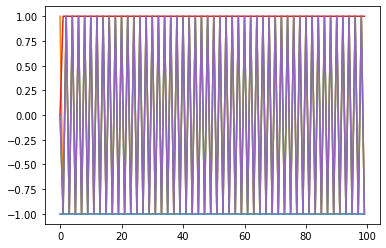

In [ ]:
num_iterations = 100
num_nodes = 5

weights = torch.randn(num_nodes, num_nodes) * 500000


# activations over time
x = torch.zeros(num_nodes, num_iterations)
# init conditions
x[0, 0] = -1
x[1, 0] = 1

# setup random input
conf = torch.tensor(np.random.choice([0, 1.0], size=(num_nodes)))
pulse_time = 50
pulse_dur = 10
mag = 3.0
impulse = 0

for t in range(1, num_iterations):
    # update activations
    x[:, t] = torch.tanh(weights @ x[:, t-1] + impulse)

    # set input
    if t > pulse_time and t < (pulse_time + pulse_dur):
        impulse = mag * conf
    else:
        impulse = 0

# plot
_, ax = plt.subplots(1, 1)
for n in range(num_nodes):
    ax.plot(range(num_iterations), x[n, :])
plt.show()   

## 5.b Sequence learning __(optional)__

When dealing with recurrent neural networks, we generally consider learning _sequences_ of data. For instance, how does the stock market fall and rise? By leatning recurrent neural networks of stock history, we can try to predict how it will act in the future. 

Let $\mathbf{y}$ denote a sequence of stock prices, over 5 days: $\mathbf{y} = \{y_1, y_2, y_3, y_4, y_5\}$ (we will use $y_t$ to denote the value of $y$ at time $t$). A recurrent neural network will predict:

$$
x_{t+1} = f(W^a[x_t \ y_t]) \\
y_{t+1} = W^b x_{t+1}
$$

where $x$ is the hidden state.

> **Task**: In the code below, I have provided weights and data, and a loop which goes through and tries to predict the incoming sequence. You need to write the predict function based on the equations above, and the predict function needs to return $y_{t+1}$ and $x_{t+1}$. You can use any choice of activation function $f$. 

**Tips** You can use `torch.cat` to concatenate togther $x$ and $y$ (denoted $[x, y]$ above). For instance, `torch.cat((x, hidden), 1)` will concatenate the matrices along the 1st dimension. 


In [ ]:
# Provides extra neural network functions
import torch.nn as nn

# define size of h
hidden_size = 6
# define size of x
input_size = 1
# length of data we model
seq_len = 20

# define a sequence of y data
y_data = torch.rand(seq_len)

# Define our weights 
W_1 = nn.Parameter(torch.rand(hidden_size + input_size, hidden_size)).float()
W_2 = nn.Parameter(torch.rand(hidden_size, input_size)).float()


# Define our predict function (todo)
def predict(y, x, W_1, W_2):
    # answer
    x_and_y = torch.cat((x, y), 1)
    hidden = torch.tanh(torch.mm(x_and_y, W_1))
    out = torch.mm(hidden, W_2)
    return out, hidden

# init hidden state
x = torch.zeros((1, hidden_size))

# loop over sequence
for t in range(seq_len):
    y_t = y_data[t].view(1, 1)
    y_t_hat, hidden = predict(y_t, x_t, W_1, W_2)
    assert (list(y_t_hat.size()) == [1, input_size]), "wrong size for y"
    assert (list(hidden.size()) == [1, hidden_size]), "wrong size for h"
print("Well done, your predict function was correct")

## 5.c Sequence learning __(Optional)__

To train a recurrent neural network, we measure the loss for each prediction in a sequence, add together these losses for the whole sequence, and backproagate. 

> **Task**: Below is code which performs a training and test loop for a recurrent neural networked trained to predict a sine wave. Fill in the missing components, and try experimenting with testing: what happens when you only pass in part of a sequence (and use the networks own predictions as data for the next time step).

In [ ]:
# Provides extra neural network functions
import torch.nn as nn
# Provides optimizers
import torch.optim as optim

# define constants
epochs = 300
hidden_size = 6
input_size = 1
output_size = 1
seq_len = 20

# Define our sin wave data
data_time_steps = np.linspace(2, 10, seq_len + 1)
data = np.sin(data_time_steps)

# define our sequence
x_data = torch.tensor(data[:-1]).float()
y_data = torch.tensor(data[1:]).float()

# Define our weights (todo)
W_1 = nn.Parameter(torch.rand(hidden_size + input_size, hidden_size)).float()
W_2 = nn.Parameter(torch.rand(hidden_size, output_size)).float()

# Setup our loss function
loss_fn = nn.MSELoss()

# Setup our optimizer
optimizer = optim.SGD([W_1, W_2], lr=0.01)

# Define our predict function (todo)
def predict(x, hidden, W_1, W_2):
    x_and_hidden = torch.cat((x, hidden), 1)
    hidden = torch.tanh(torch.mm(x_and_hidden, W_1))
    out = torch.mm(hidden, W_2)
    return out, hidden

# Training loop
for epoch in range(1000):
    optimizer.zero_grad()
    # init hidden state
    hidden = torch.zeros((1, hidden_size))
    loss = 0
    for t in range(x_data.size(0)):
        x_t = x_data[t].view(1, 1)
        y_t = y_data[t].view(1, 1)
        # predict next hidden and state
        (y_t_hat, hidden) = predict(x_t, hidden, W_1, W_2)
        # accumulate loss
        loss = loss + loss_fn(y_t_hat, y_t)
    loss.backward()
    optimizer.step()  

# Test network
hidden = torch.zeros((1, hidden_size))
predictions = []

for t in range(x_data.size(0)):
    x_t = x_data[t].view(-1, 1)
    (y_t_hat, hidden) = predict(x_t, hidden, W_1, W_2)
    predictions.append(y_t_hat.data.numpy().ravel()[0])

plt.scatter(data_time_steps[:-1], x_data.data.numpy(), s=90, label="Actual")
plt.scatter(data_time_steps[1:], predictions, label="Predicted")
plt.legend()
plt.show()
        

